#### Objetivo 

Este proejto tem como objetivo desenvolver competências na análise e processamento de dados textuais em português. O projeto inclui etapas de linguística computacional e técnicas avançadas de PLN, como análise de sentimentos, modelagem de tópicos, usando dados extraídos de uma fonte variada em português, como o Reddit.

Começamos por importar a biblioteca praw para acessar e coletar dados da API do Reddit

In [40]:
import praw

Primeiramente, utilizamos o dotenv para carregar as credenciais do arquivo .env, onde as informações estão armazenadas. Em seguida, lemos essas credenciais utilizando os.getenv() para obter valores como client_id, client_secret, user_agent, username e password. Essas configurações são fundamentais para estabelecer uma conexão segura com a API do Reddit, permitindo que possamos acessar e utilizar suas funcionalidades programaticamente.

In [41]:
from dotenv import load_dotenv
import os

load_dotenv()

CLIENT_ID = os.getenv("R_CLIENT_ID")
CLIENT_SECRET = os.getenv("R_CLIENT_SECRET")
USER_AGENT = os.getenv("R_USER_AGENT")
USERNAME = os.getenv("R_USERNAME")
PASSWORD = os.getenv("R_PASSWORD")

Estabelecemos a conexão com a API do Reddit utilizando as credenciais carregadas anteriormente, criando a instância reddit_instance para interagir com o Reddit.

In [42]:
reddit_instance = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT,
    username=USERNAME,
    password=PASSWORD
)

Acessamos o subreddit “portugal2” através da instância reddit_instance para começar a coletar dados desse fórum específico no Reddit. Este subreddit é um fórum português onde os usuários expressam opiniões livres e diversas.

In [43]:
subreddit = reddit_instance.subreddit('portugal2')
subreddit

Subreddit(display_name='portugal2')

Coletamos os 1000 posts mais populares do subreddit “portugal2” no último ano, convertendo os timestamps para datas legíveis e salvando os dados (título, conteúdo, número de comentários e data de criação) num Excel chamado ‘reddit.xlsx’.

In [44]:
import pandas as pd
from datetime import datetime

top_posts = subreddit.top(limit=1000, time_filter="year")

posts_df = []
for post in top_posts:
    # Converte o timestamp Unix para um formato de data legível
    post_date = datetime.utcfromtimestamp(post.created_utc).strftime('%d-%m-%Y')

    # Adiciona os dados do post à lista
    posts_df.append({
        'Title': post.title,
        'Content': post.selftext,
        'Number of Comments': post.num_comments,
        'Created': post_date  # Data de criação
    })
posts_df = pd.DataFrame(posts_df)
posts_df.to_excel('reddit.xlsx', index=False)

#### Eliminar as linhas em branco

Fizemos isso para remover os posts com conteúdo vazio, pois muitos deles eram imagens ou posts sem texto, deixando o arquivo mais limpo e relevante para a análise.

In [45]:
# Carregar o arquivo Excel 
dataset_path = 'reddit.xlsx'
posts_df = pd.read_excel(dataset_path)

# Remover linhas onde a coluna "Content" está vazia
posts_df = posts_df[posts_df['Content'].str.strip() != ""]
posts_df = posts_df[posts_df['Content'].notna()]

# Salvar o dataset limpo em um novo arquivo Excel
cleaned_dataset_path = 'reddit_cleaned.xlsx'
posts_df.to_excel(cleaned_dataset_path, index=False)

#### Pré-processamento de Texto (VER)

Aplicamos um processo de pré-processamento de texto, onde transformamos todo o conteúdo dos posts em minúsculas, removemos caracteres especiais e números, tokenizamos as palavras, eliminamos stopwords e lematizamos as palavras. Isso ajuda a limpar e padronizar os textos para análises futuras. O DataFrame processado foi então salvo em um novo arquivo Excel chamado ‘reddit_cleaned_processed.xlsx’.

In [46]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Certifique-se de baixar os recursos necessários do NLTK antes de executar
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Carregar as stopwords em português
stop_words = set(stopwords.words('portuguese'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Converter para minúsculas
    text = text.lower()
    
    # Remover caracteres especiais, mantendo apenas letras e números
    text = re.sub(r'[^a-zá-úãõàâäçéêíóôúùñ\s]', '', text)
    
    # Remover números 
    text = re.sub(r'\d+', '', text)
    
    # Tokenizar as palavras
    words = word_tokenize(text)
    
    # Remover stopwords
    words_filtered = [word for word in words if word not in stop_words]
    
    # Lematizar as palavras
    words_lemmatized = [lemmatizer.lemmatize(word) for word in words_filtered]
    
    # Juntar as palavras lematizadas de volta em uma string
    return ' '.join(words_lemmatized)

# Aplicar o pré-processamento ao conteúdo
posts_df['Content'] = posts_df['Content'].apply(lambda x: clean_text(str(x)))

# Salvar o DataFrame processado em um arquivo Excel
posts_df.to_excel('reddit_cleaned_processed.xlsx', index=False)

# Exibir as primeiras linhas do DataFrame processado
print(posts_df.head())

[nltk_data] Downloading package punkt to /Users/tiago/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tiago/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tiago/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                Title  \
1                              Vamos limpar Portugal!   
2                  Táxi falso no aeroporto de Lisboa    
6   Bloqueiam a estrada para pedir dinheiro e furt...   
7                  Para quem ainda não compreendeu...   
10                     A Maria João está desaparecida   

                                              Content  Number of Comments  \
1   nata pessoas vão tornar possivel cristina rodr...                 610   
2                         un turistas serem enganados                 138   
6   faro bloqueiam estrada modo obrigar carros par...                 147   
7       agora vejam lá querem surpresas daqui doi ano                 132   
10  maria joão ano fugiu casa namorado ano dia ant...                 319   

       Created  
1   14-03-2024  
2   10-07-2024  
6   28-07-2024  
7   27-03-2024  
10  10-04-2024  


#### Análise Exploratória dos Dados

Esta parte do código é dedicada apenas à análise exploratória dos dados. Começamos por carregar o dataset processado e, em seguida, realizamos a tokenização do texto, separando as palavras. O código conta a frequência das palavras e gera um gráfico de barras para exibir as 20 palavras mais frequentes. Também cria uma nuvem de palavras para ilustrar visualmente as palavras mais recorrentes. Além disso, o código realiza uma análise de n-grams (bigramas e trigramas), identificando as combinações mais comuns de palavras e visualizando suas frequências em gráficos.

[nltk_data] Downloading package punkt to /Users/tiago/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/lm/rsrn4zyx5l7_g9y1n8jbfgqh0000gn/T/ipykernel_14387/820633143.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


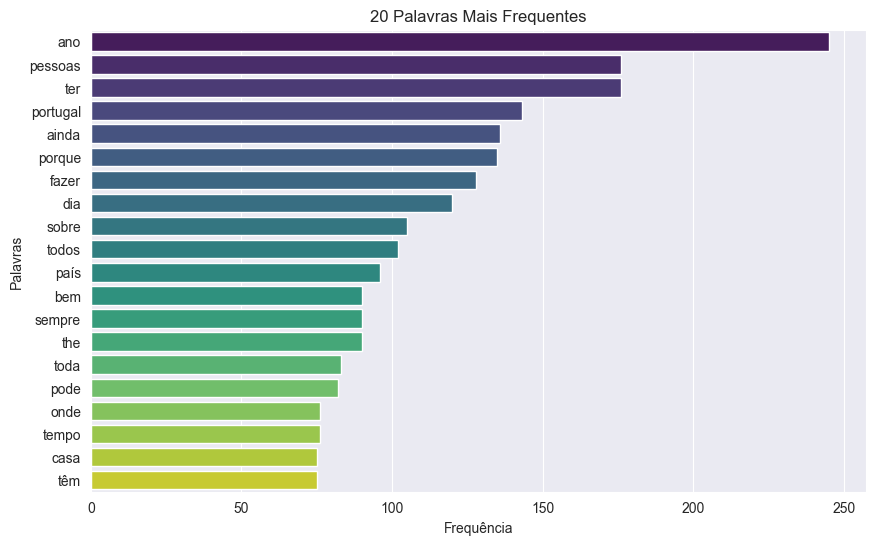

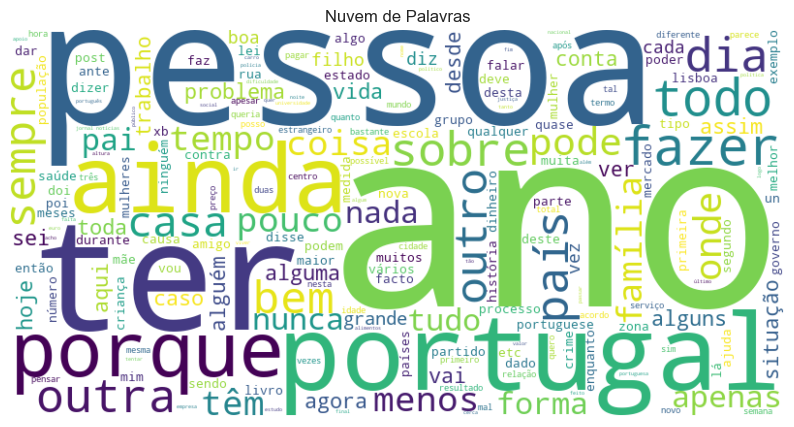

Top 10 Bigramas:
jornal notícias: 27
toda gente: 22
xb jornal: 19
cada vez: 18
muitas vezes: 17
milhões euro: 17
reino unido: 16
mil euro: 15
redes sociais: 14
cinco ano: 12

Top 10 Trigramas:
xb jornal notícias: 17
jornal notícias março: 8
mil milhões euro: 8
gonçalo nascimento rodrigues: 7
agência portuguesa ambiente: 5
jornal notícias janeiro: 5
crédito habitação concedido: 5
jornal notícias maio: 4
out of the: 4
expresidente agência portuguesa: 4


/var/folders/lm/rsrn4zyx5l7_g9y1n8jbfgqh0000gn/T/ipykernel_14387/820633143.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_counts, y=bigram_words, palette="coolwarm")


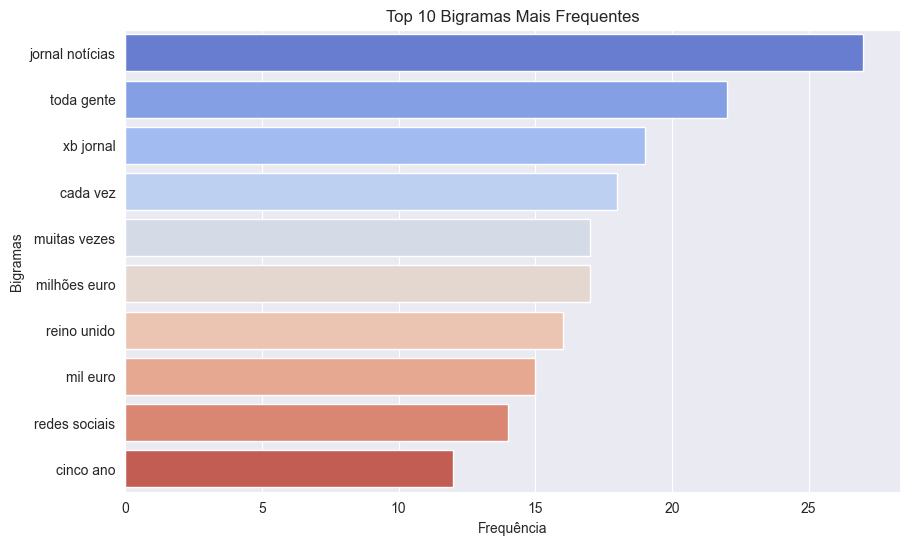

/var/folders/lm/rsrn4zyx5l7_g9y1n8jbfgqh0000gn/T/ipykernel_14387/820633143.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trigram_counts, y=trigram_words, palette="coolwarm")


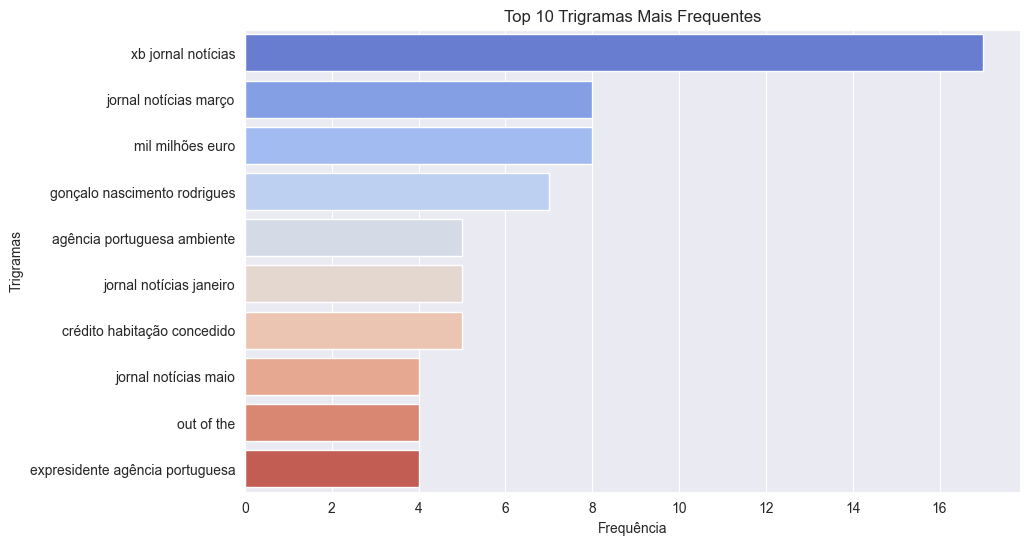

AttributeError: 'DataFrame' object has no attribute 'sorted'

In [52]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams
from wordcloud import WordCloud
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk

# Certifique-se de baixar os recursos necessários do NLTK
nltk.download('punkt')

# Carregar o dataset processado
dataset_path = 'reddit_cleaned_processed.xlsx'
df = pd.read_excel(dataset_path)

# Unir todos os textos da coluna 'Content' em uma única string
all_text = " ".join(df['Content'].dropna())

# Tokenização: separar todas as palavras
tokens = word_tokenize(all_text)

# Contar a frequência das palavras
word_freq = Counter(tokens)

# Plotar os 20 termos mais frequentes
most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words, palette="viridis")
plt.title("20 Palavras Mais Frequentes")
plt.xlabel("Frequência")
plt.ylabel("Palavras")
plt.show()

# Gerar nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de Palavras")
plt.show()

# Análise de n-grams (bigramas e trigramas)
def analyze_ngrams(tokens, n):
    ngram_counts = Counter(ngrams(tokens, n))
    return ngram_counts.most_common(10)

# Bigramas
bigrams = analyze_ngrams(tokens, 2)
print("Top 10 Bigramas:")
for bigram, freq in bigrams:
    print(f"{' '.join(bigram)}: {freq}")

# Trigramas
trigrams = analyze_ngrams(tokens, 3)
print("\nTop 10 Trigramas:")
for trigram, freq in trigrams:
    print(f"{' '.join(trigram)}: {freq}")

# Visualizar os bigramas em um gráfico
bigram_words = [' '.join(bigram) for bigram, freq in bigrams]
bigram_counts = [freq for bigram, freq in bigrams]

plt.figure(figsize=(10, 6))
sns.barplot(x=bigram_counts, y=bigram_words, palette="coolwarm")
plt.title("Top 10 Bigramas Mais Frequentes")
plt.xlabel("Frequência")
plt.ylabel("Bigramas")
plt.show()

# Visualizar os trigramas em um gráfico
trigram_words = [' '.join(trigram) for trigram, freq in trigrams]
trigram_counts = [freq for trigram, freq in trigrams]

plt.figure(figsize=(10, 6))
sns.barplot(x=trigram_counts, y=trigram_words, palette="coolwarm")
plt.title("Top 10 Trigramas Mais Frequentes")
plt.xlabel("Frequência")
plt.ylabel("Trigramas")
plt.show()

df_sorted = df.sort_values(by='Number of Comments', ascending=False)
top_10_posts = df.sorted[['Title', 'Number of Comments']].head(10)
print(top_10_posts)

#### Analise de Sentimentos 

Esta parte do código realizamos a análise de sentimentos nos posts do Reddit usando o modelo pré-treinado RoBERTa. O texto é tokenizado e classificado como Negative, Neutral ou Positive. A classificação de sentimento é adicionada ao dataset em uma nova coluna. Por fim, é feita uma contagem dos diferentes sentimentos nos posts.

In [48]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Carrega o modelo e o tokenizer RoBERTa
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Função para analisar o sentimento do texto com tokenização manual
def analyze_sentiment(text):
    if isinstance(text, str) and pd.notnull(text):
        # Tokeniza o texto
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        
        # Passa pelo modelo
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Obtém as probabilidades e determina o rótulo de sentimento
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment_label = torch.argmax(probs).item()
        
        # Mapeia os índices para os rótulos de sentimento: 0=Negative, 1=Neutral, 2=Positive
        labels = ['Negative', 'Neutral', 'Positive']
        return labels[sentiment_label]
    else:
        return "No analysis"

# Carregar o dataset limpo
dataset_path = 'reddit_cleaned_processed.xlsx'  # Arquivo limpo gerado anteriormente
df = pd.read_excel(dataset_path)

# Aplica a função de análise de sentimento ao conteúdo do post e cria uma nova coluna 'sentiment'
df['Sentiment'] = df['Content'].apply(analyze_sentiment)

# Salva o DataFrame com a nova coluna de sentimento em um novo arquivo Excel
output_path = 'reddit_top_posts_with_sentiment.xlsx'
df.to_excel(output_path, index=False)

# Contar os valores únicos na coluna 'Sentiment'
sentiment_counts = df['Sentiment'].value_counts()

Este código realiza a contagem do número de posts classificados como positivos, neutros e negativos da coluna ‘Sentiment’.

In [49]:
# Contar a quantidade de sentimentos em cada categoria
sentiment_counts = df['Sentiment'].value_counts()

# Exibir os resultados
print("Comentários Positivos:", sentiment_counts.get('Positive', 0))
print("Comentários Neutros:", sentiment_counts.get('Neutral', 0))
print("Comentários Negativos:", sentiment_counts.get('Negative', 0))

Comentários Positivos: 0
Comentários Neutros: 538
Comentários Negativos: 5


 Inicialmente, limpamos os dados e separamos as variáveis de texto e sentimento. Em seguida, aplicamos a vetorização TF-IDF para converter os textos em números e usamos o SMOTE para balancear as classes, pois havia um desbalanceamento no dataset. Para a classificação, utilizamos o modelo Random Forest com ajuste de peso das classes. Avaliamos o desempenho com métricas como acurácia, relatório de classificação e matriz de confusão. O modelo apresentou um bom desempenho, embora ainda haja espaço para melhorias, especialmente no balanceamento das classes.

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Carregar o dataset
df = pd.read_excel('reddit_top_posts_with_sentiment.xlsx')

# Remover linhas com NaN na coluna 'Content'
df = df.dropna(subset=['Content'])

# Separar as features (texto) e o target (sentimento)
X = df['Content']  # A coluna com os textos
y = df['Sentiment']  # A coluna com os rótulos (positivo, negativo, neutro)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vetorização com TF-IDF
tfidf = TfidfVectorizer(max_features=1000)  # Limitar o número de features para 1000
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Aplicar SMOTE para balanceamento das classes
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)
print(pd.Series(y_train_res).value_counts())

# Criar e treinar o modelo Random Forest com class_weight='balanced'
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
model_rf.fit(X_train_res, y_train_res)

# Fazer previsões no conjunto de teste
y_pred_rf = model_rf.predict(X_test_tfidf)

# Avaliar o modelo
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf))

# Exibir a Matriz de Confusão
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))

Sentiment
Neutral     430
Negative    430
Name: count, dtype: int64
Acurácia: 0.9908256880733946

Relatório de Classificação:
               precision    recall  f1-score   support

    Negative       0.50      1.00      0.67         1
     Neutral       1.00      0.99      1.00       108

    accuracy                           0.99       109
   macro avg       0.75      1.00      0.83       109
weighted avg       1.00      0.99      0.99       109


Matriz de Confusão:
 [[  1   0]
 [  1 107]]


#### Modelação de Tópicos

Aplicamos o modelo LDA para identificar tópicos em posts do Reddit. Primeiro, carregamos e processamos os dados, removendo as linhas vazias e dividindo os textos em palavras. Em seguida, criamos um dicionário e um corpus para o modelo, que é treinado para identificar três tópicos. Por fim, exibe os tópicos encontrados, mostrando as palavras mais representativas de cada um. Este processo ajuda a entender melhor os temas subjacentes nos posts analisados.

In [51]:
import pandas as pd
from gensim import corpora
from gensim.models.ldamodel import LdaModel

# Carregar o dataset
file_path = 'reddit_top_posts_with_sentiment.xlsx'
df = pd.read_excel(file_path)

# Usar a coluna 'Content' e remover linhas vazias
texts = df['Content'].dropna()

# Dividir os textos em listas de palavras sem qualquer pré-processamento
texts_cleaned = [text.split() for text in texts]

# Criar dicionário (id2word) e corpus (necessários para LDA)
id2word = corpora.Dictionary(texts_cleaned)
corpus = [id2word.doc2bow(text) for text in texts_cleaned]

# Treinar o modelo LDA para identificar 3 tópicos
lda_model = LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=15)

# Exibir os tópicos descobertos
print("\nTópicos identificados:\n")
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico #{idx + 1}: {topic}\n")



Tópicos identificados:

Tópico #1: 0.006*"ano" + 0.005*"pessoas" + 0.003*"fazer" + 0.003*"ter" + 0.003*"ainda" + 0.003*"sobre" + 0.003*"portugal" + 0.003*"porque" + 0.002*"todos" + 0.002*"onde"

Tópico #2: 0.006*"ano" + 0.006*"the" + 0.004*"to" + 0.003*"i" + 0.003*"and" + 0.003*"fazer" + 0.003*"dia" + 0.003*"pessoas" + 0.003*"bem" + 0.003*"ter"

Tópico #3: 0.005*"ter" + 0.004*"portugal" + 0.004*"pessoas" + 0.003*"ano" + 0.003*"porque" + 0.003*"ainda" + 0.003*"país" + 0.003*"dia" + 0.003*"casa" + 0.002*"pode"


#### Conclusões Finais